# Where should a drinks company run promotions?

## 📖 Background
Your company owns a chain of stores across Russia that sell a variety of alcoholic drinks. The company recently ran a wine promotion in Saint Petersburg that was very successful. Due to the cost to the business, it isn’t possible to run the promotion in all regions. The marketing team would like to target 10 other regions that have similar buying habits to Saint Petersburg where they would expect the promotion to be similarly successful.

### The data
The marketing team has sourced you with historical sales volumes per capita for several different drinks types.

- "year" - year (1998-2016)
- "region" - name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast
- "wine" - sale of wine in litres by year per capita
- "beer" - sale of beer in litres by year per capita
- "vodka" - sale of vodka in litres by year per capita
- "champagne" - sale of champagne in litres by year per capita
- "brandy" - sale of brandy in litres by year per capita

# Competition - Drinks Promotions
## James Morgan (jhmmorgan)
*2021-10-20*

## Assumptions and restrictions
Before we begin, it's worth noting that we'll be making a number of assumptions within the analysis and have a number of restrictions.
 - We don't know when the wine marketing promotion ran.
     - We know that it was run in Saint Petersburg recently, however our data goes up to 2016 and it's unclear if the promotion ran after 2016, or if 2016 is considered "recent".
     - We'll therefore assume the marketing promotion ran after 2016.
 - We don't know the demographics of each region, or how much residents spent on alcohol across all brands.
     - We only know how much was spent, per capita for our brand.
 - We don't know why there is missing data
     - For example, did our company not sell achohol to those regions, or was there no interest in our brand?
 - We're unaware of the compeition.

## 1. Set Up
### 1.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.pipeline import make_pipeline

### 1.2 Default classes
Used for better printing outputs.

In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   HEADER = '\033[1m' + '\033[4m'
   END = '\033[0m'

### 1.3 Loading the data

In [3]:
import pandas as pd
df = pd.read_csv(r'./data/russian_alcohol_consumption.csv')
df.head()

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


## 2. EDA (Exploratory Data Analysis)
### 2.1 Data Check

In [4]:
# Data Type Check
df_check = pd.DataFrame({"Column": df.columns, "Dtype": df.dtypes.astype("str").tolist(), 
                         "Sample1": df.loc[1].tolist(),
                         "Sample2": df.loc[50].tolist(), 
                         "Sample3": df.loc[500].tolist()})
print(color.HEADER + "Data Types for all features in the data" + color.END)
print(df_check.to_string())

Data Types for all features in the data
      Column    Dtype     Sample1    Sample2          Sample3
0       year    int64        1998       1998             2003
1     region   object  Altai Krai  Perm Krai  Khabarovsk Krai
2       wine  float64         3.3        3.2              3.8
3       beer  float64        19.2       19.0             47.4
4      vodka  float64        11.3       16.7             15.2
5  champagne  float64         1.1        0.9              0.7
6     brandy  float64         0.1        0.2              0.4


In [5]:
print(color.HEADER + "Which features contain null values?" + color.END)
df_missing = pd.concat([df.isnull().sum()[df.isnull().sum()>0],round((df.isnull().sum()[df.isnull().sum()>0]/len(df))*100,2)], axis=1)
df_missing.columns = ["No.", "%"]
df_missing

Which features contain null values?


,No.,%
wine,63,3.90
beer,58,3.59
vodka,61,3.78
champagne,63,3.90
brandy,66,4.09


##### Observations:
There doesn't appear to be anything unusual with the data types.
However, we do have several missing features in all of the alcoholic features.

In [6]:
print(color.HEADER + "Which regions have missing values?" + color.END)
df_missing_grouped = df.groupby(["region"]).apply(lambda x: x.isnull().sum())
df_missing_grouped = df_missing_grouped[df_missing_grouped.sum(axis=1)>0]
df_missing_grouped

Which regions have missing values?


,year,region,wine,beer,vodka,champagne,brandy
region,,,,,,,
Chechen Republic,0,0,19,16,19,19,19
Republic of Crimea,0,0,16,16,16,16,16
Republic of Ingushetia,0,0,12,10,10,12,15
Sevastopol,0,0,16,16,16,16,16


We need to decide what to do with these missing values.
First, let's see if any of the data that is missing is from the last few years.  The thinking is that some regions might only have started selling our brand in recent years, whereas others may not be popular in recent years at all.

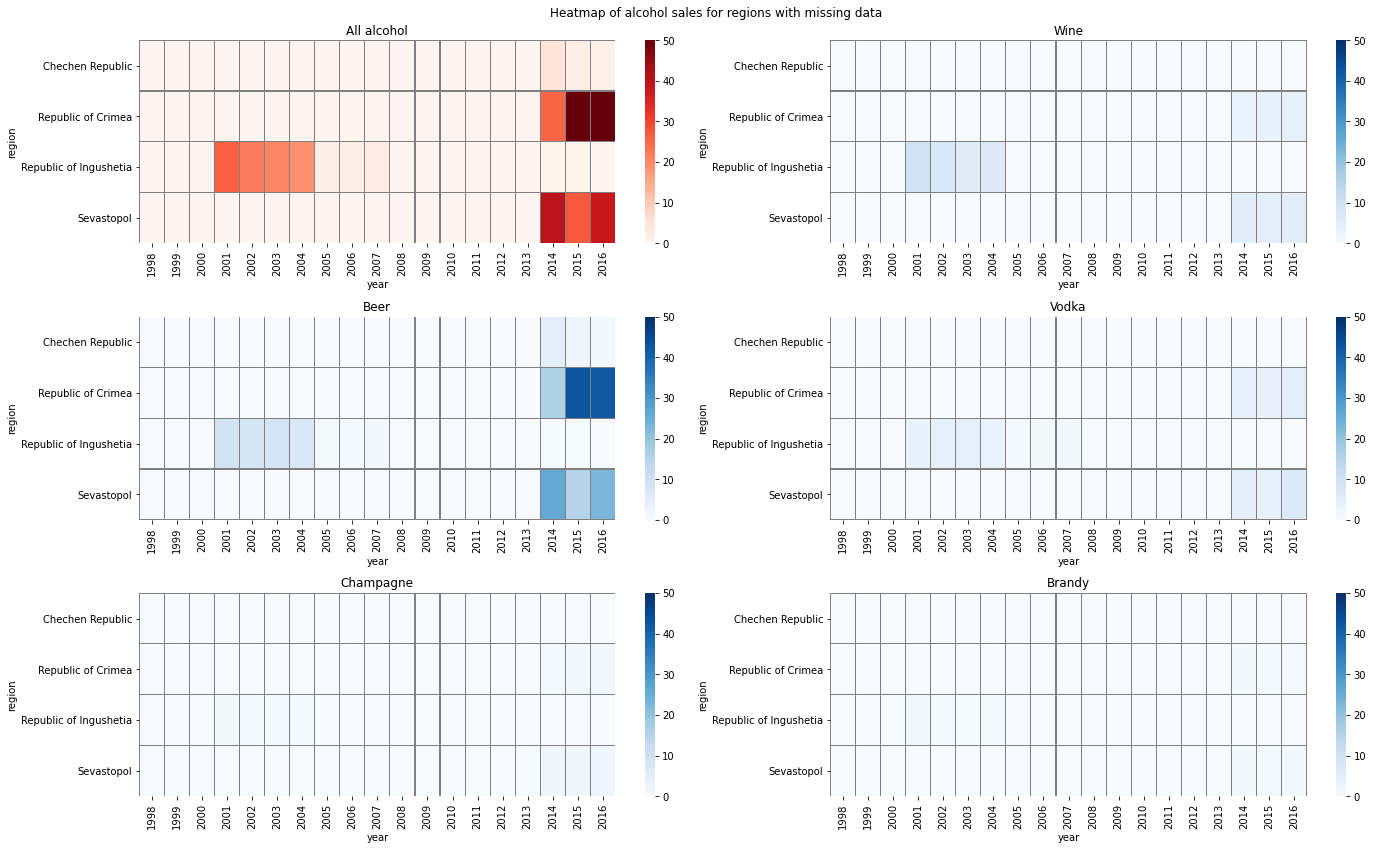

In [7]:
df_missing_regions = df_missing_grouped.index.values
filter1 = df.region.isin(df_missing_regions)
df_filtered = df[(filter1)].sort_values(by=["region", "year"])
df_filtered.fillna(0, inplace = True)
df_filtered["total"] = df_filtered.wine + \
                       df_filtered.beer + \
                       df_filtered.vodka + \
                       df_filtered.champagne + \
                       df_filtered.brandy
df_filtered["year"] = df_filtered.year.astype(str)

df_filtered_wine = pd.pivot_table(df_filtered[["year", "region", "wine"]], values="wine", index="region", columns=["year"])
df_filtered_beer = pd.pivot_table(df_filtered[["year", "region", "beer"]], values="beer", index="region", columns=["year"])
df_filtered_vodka = pd.pivot_table(df_filtered[["year", "region", "vodka"]], values="vodka", index="region", columns=["year"])
df_filtered_champagne = pd.pivot_table(df_filtered[["year", "region", "champagne"]], values="champagne", index="region", columns=["year"])
df_filtered_brandy = pd.pivot_table(df_filtered[["year", "region", "brandy"]], values="brandy", index="region", columns=["year"])
df_filtered_total = pd.pivot_table(df_filtered[["year", "region", "total"]], values="total", index="region", columns=["year"])

plt.figure(figsize = (20,12))
plt.suptitle("Heatmap of alcohol sales for regions with missing data")
plt.subplot(3, 2, 1)
plt.title("All alcohol")
sns.heatmap(df_filtered_total, vmin = 0, vmax = 50, cmap = "Reds", linecolor = "grey", linewidth = 0.1)

plt.subplot(3, 2, 2)
plt.title("Wine")
sns.heatmap(df_filtered_wine, vmin = 0, vmax = 50, cmap = "Blues", linecolor = "grey", linewidth = 0.1)

plt.subplot(3, 2, 3)
plt.title("Beer")
sns.heatmap(df_filtered_beer, vmin = 0, vmax = 50, cmap = "Blues", linecolor = "grey", linewidth = 0.1)
          
plt.subplot(3, 2, 4)
plt.title("Vodka")
sns.heatmap(df_filtered_vodka, vmin = 0, vmax = 50, cmap = "Blues", linecolor = "grey", linewidth = 0.1)

plt.subplot(3, 2, 5)
plt.title("Champagne")
sns.heatmap(df_filtered_champagne, vmin = 0, vmax = 50, cmap = "Blues", linecolor = "grey", linewidth = 0.1)

plt.subplot(3, 2, 6)
plt.title("Brandy")
sns.heatmap(df_filtered_brandy, vmin = 0, vmax = 50, cmap = "Blues", linecolor = "grey", linewidth = 0.1)

plt.tight_layout()
plt.show()

Interesting!

**Chechen Republic** has barely any sales data. We'll be unable to predict the impact of a marketing campaign and they certainly won't be in the top 10, so we're safe to remove them from the data rather than fill in the missing data.

**Republic of Ingushetia** has had some sales from 2001, but these decreased over several years before disappearing completely.  Similar to Chechen Republic, we're safe to remove their data completely.
Of course, we could change the sales to zero as an alternative.

**Republic of Crimea** and **Sevastopol** however are a different story.  They have no historic sales, however they have been selling for the last three years, which is a good indication of ongoing sales in the future.

We have a number of options.
 - We could change all of their historic data to 0;
 - We could change their historic data to the mean of their current sales;
 - We could change their historic data to match their first year of sales (2014).

I feel Option 2 - using the mean - is a good reflection. Let's implement our changes and check no missing values remain.

In [8]:
df_cleaned = df[~df.region.isin(["Chechen Republic", "Republic of Ingushetia"])]#.set_index(["region", "year"])

wine_series = round(df_cleaned.groupby("region").wine.mean(),0)
beer_series = round(df_cleaned.groupby("region").beer.mean(),0)
vodka_series = round(df_cleaned.groupby("region").vodka.mean(),0)
champagne_series = round(df_cleaned.groupby("region").champagne.mean(),0)
brandy_series = round(df_cleaned.groupby("region").brandy.mean(),0)
df_cleaned = df_cleaned.fillna({"wine": df_cleaned["region"].apply(lambda x: wine_series[x]),
                                "beer": df_cleaned["region"].apply(lambda x: beer_series[x]),
                                "vodka": df_cleaned["region"].apply(lambda x: vodka_series[x]),
                                "champagne": df_cleaned["region"].apply(lambda x: champagne_series[x]),
                                "brandy": df_cleaned["region"].apply(lambda x: brandy_series[x]),})
df_cleaned["total"] = df_cleaned.wine + df_cleaned.beer + df_cleaned.vodka + df_cleaned.champagne + df_cleaned.brandy

In [9]:
print(color.BOLD + color.RED + f"No. of missing values after amendments: {df_cleaned.isna().sum().sum()}" + color.END)

No. of missing values after amendments: 0


### 2.2 Looking at Saint Petersburg sales

Let's now look at the Saint Petersburg sales data to understand the full impact of their marketing campaign.

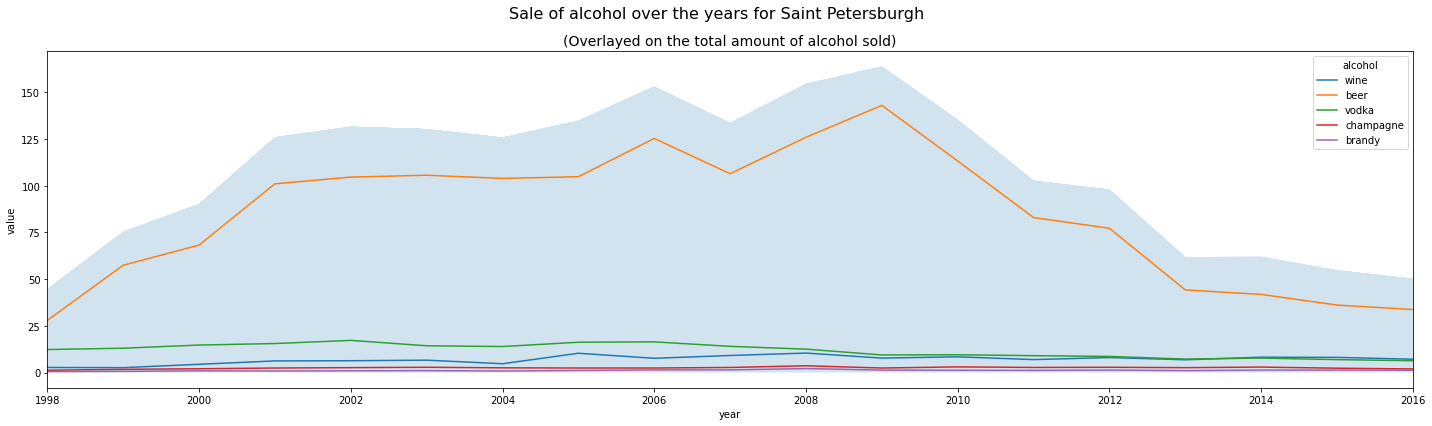

In [10]:
df_filtered = df_cleaned[df_cleaned.region == "Saint Petersburg"]

df_melt = pd.melt(df_filtered, 
                  value_vars = ["wine", "beer", "vodka", "champagne", "brandy"],
                  var_name = "alcohol",
                  id_vars = ["region", "year", "total"])


plt.figure(figsize = (20,6))
plt.suptitle("Sale of alcohol over the years for Saint Petersburgh", fontsize=16)
plt.title("(Overlayed on the total amount of alcohol sold)", fontsize=14)
plt.fill_between(df_melt['year'], df_melt['total'], alpha=0.2)
sns.lineplot(data = df_melt, x = "year", y = "value", hue = "alcohol")
plt.xlim([1998, 2016])
plt.tight_layout()
plt.show()

Hmm. This doesn't show us a lot.
We can see that **beer** sales are much stronger, but are in decline.  The detail on the other types of alcohol are lost at this scale.

How do **Saint Petersburg** sales ranking compared to other regions?

In [11]:
rank_saint_petersburg_09 = pd.DataFrame(df_cleaned[df_cleaned.year==2009])[["year", "region", "total"]].sort_values("total", ascending = False)
rank_saint_petersburg_09["row"] = np.arange(rank_saint_petersburg_09.shape[0])+1
rsp_09 = rank_saint_petersburg_09.loc[rank_saint_petersburg_09.region == "Saint Petersburg", "row"].values[0]

rank_saint_petersburg_13 = pd.DataFrame(df_cleaned[df_cleaned.year==2013])[["year", "region", "total"]].sort_values("total", ascending = False)
rank_saint_petersburg_13["row"] = np.arange(rank_saint_petersburg_13.shape[0])+1
rsp_13 = rank_saint_petersburg_13.loc[rank_saint_petersburg_13.region == "Saint Petersburg", "row"].values[0]

rank_saint_petersburg_16 = pd.DataFrame(df_cleaned[df_cleaned.year==2016])[["year", "region", "total"]].sort_values("total", ascending = False)
rank_saint_petersburg_16["row"] = np.arange(rank_saint_petersburg_16.shape[0])+1
rsp_16 = rank_saint_petersburg_16.loc[rank_saint_petersburg_16.region == "Saint Petersburg", "row"].values[0]

print(color.BOLD + "In 2009, Saint Petersburg ranked: " + color.RED + f"No.{rsp_09}" + color.END + color.BOLD + " for alcohol sales." + color.END)
print(color.BOLD + "In 2013, Saint Petersburg ranked: " + color.RED + f"No.{rsp_13}" + color.END + color.BOLD + " for alcohol sales." + color.END)
print(color.BOLD + "In 2016, Saint Petersburg ranked: " + color.RED + f"No.{rsp_16}" + color.END + color.BOLD + " for alcohol sales." + color.END)





In 2009, Saint Petersburg ranked: No.1 for alcohol sales.
In 2013, Saint Petersburg ranked: No.67 for alcohol sales.
In 2016, Saint Petersburg ranked: No.72 for alcohol sales.


There are 83 regions included in the data.  They were the number 1 region for sales in 2009 but by 2016, they've dropped down to 72nd place.

Let's explore the % of sales for each type of alcohol compared to the total volumn sold per year.

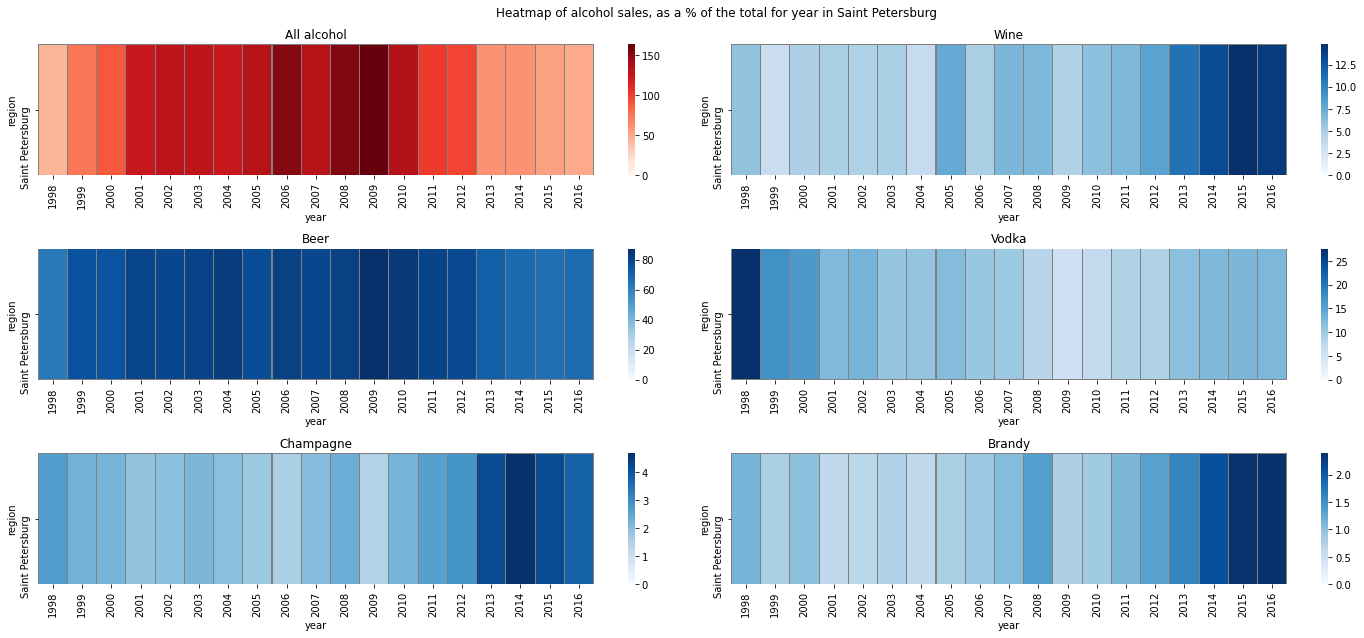

In [12]:
df_eda = df_cleaned[df_cleaned.region == "Saint Petersburg"].sort_values(by=["region", "year"])

df_eda["wine"] = (df_eda.wine / df_eda.total) * 100
df_eda["beer"] = (df_eda.beer / df_eda.total) * 100
df_eda["vodka"] = (df_eda.vodka / df_eda.total) * 100
df_eda["champagne"] = (df_eda.champagne / df_eda.total) * 100
df_eda["brandy"] = (df_eda.brandy / df_eda.total) * 100
df_eda["year"] = df_eda.year.astype(str)

df_eda_wine = pd.pivot_table(df_eda[["year", "region", "wine"]], values="wine", index="region", columns=["year"])
df_eda_beer = pd.pivot_table(df_eda[["year", "region", "beer"]], values="beer", index="region", columns=["year"])
df_eda_vodka = pd.pivot_table(df_eda[["year", "region", "vodka"]], values="vodka", index="region", columns=["year"])
df_eda_champagne = pd.pivot_table(df_eda[["year", "region", "champagne"]], values="champagne", index="region", columns=["year"])
df_eda_brandy = pd.pivot_table(df_eda[["year", "region", "brandy"]], values="brandy", index="region", columns=["year"])
df_eda_total = pd.pivot_table(df_eda[["year", "region", "total"]], values="total", index="region", columns=["year"])

plt.figure(figsize = (20,9))

plt.suptitle("Heatmap of alcohol sales, as a % of the total for year in Saint Petersburg")
plt.subplot(3, 2, 1)
plt.title("All alcohol")
sns.heatmap(df_eda_total, vmin = 0, cmap = "Reds", linecolor = "grey", linewidth = 0.1)

plt.subplot(3, 2, 2)
plt.title("Wine")
sns.heatmap(df_eda_wine, vmin = 0, cmap = "Blues", linecolor = "grey", linewidth = 0.1)

plt.subplot(3, 2, 3)
plt.title("Beer")
sns.heatmap(df_eda_beer, vmin = 0, cmap = "Blues", linecolor = "grey", linewidth = 0.1)
          
plt.subplot(3, 2, 4)
plt.title("Vodka")
sns.heatmap(df_eda_vodka, vmin = 0, cmap = "Blues", linecolor = "grey", linewidth = 0.1)

plt.subplot(3, 2, 5)
plt.title("Champagne")
sns.heatmap(df_eda_champagne, vmin = 0, cmap = "Blues", linecolor = "grey", linewidth = 0.1)

plt.subplot(3, 2, 6)
plt.title("Brandy")
sns.heatmap(df_eda_brandy, vmin = 0, cmap = "Blues", linecolor = "grey", linewidth = 0.1)

plt.tight_layout()
plt.show()

This is interesting! 

Beer sales from **Saint Petersburg** are certainly greater than other alcohols, making up the most of their sales, however this has decreased in recent years, with more residents over the last three to four years buying wine, with a slight increase in champagne and brandy too.

Of course, what we don't know is when the wine promotion ran from.  If it ran from 2014 to 2016, then we can certainly see the impact.  If it ran from 2017 onwards (which we have no data for), then Saint Petersburg was targeted well, due to their growing interest in wine in the few years prior.

**I'm going to make the assumption that this task is up to date, i.e. the wine promotion ran from 2017 onwards and we're therefore looking for other regions who;**
 - Have a low volumns of sales,
 - Out of the sales, they spend a little on wine
 - The spending on wine has started to increase in recent years

This is because, whilst the % of wine sales in Saint Petersburg has increased around 2014 to 2016, there's not a noticeable increase where I'd consider a campaign to be a huge success that you want to replicate.


## 3. Clustering similar regions to Saint Petersburg
### 3.1 K-Means

To start, we're going to use K-Means clustering to identify regions that are similar to Saint Petersburg.

To do this, we'll need to pre-process the data to focus on each region over the years. We'll also focus on the % of sales for each regions total.

In [13]:
regions = df_cleaned.region
df_groupings = pd.DataFrame(regions).drop_duplicates()

In [14]:
df_prepro = df_cleaned.copy()
df_prepro["region"] = df_prepro.region.astype("category")
df_prepro = df_prepro[df_prepro.year > 2010]

df_prepro["wine"] = (df_prepro.wine / df_prepro.total)
df_prepro["beer"] = (df_prepro.beer / df_prepro.total)
df_prepro["vodka"] = (df_prepro.vodka / df_prepro.total)
df_prepro["champagne"] = (df_prepro.champagne / df_prepro.total)
df_prepro["brandy"] = (df_prepro.brandy / df_prepro.total)


df_prepro = df_prepro.melt(id_vars = ["region", "year"], value_vars = ["wine", "beer", "vodka", "champagne", "brandy"]).pivot(values = ["value"], index = "region", columns = ["variable", "year"])
print(color.HEADER + "Saint Petersburg's pre-processed data." + color.END)
df_prepro[df_prepro.index == "Saint Petersburg"]

Saint Petersburg's pre-processed data.


value                                                   \
variable              wine                                                    
year                  2011      2012      2013      2014     2015      2016   
region                                                                        
Saint Petersburg  0.067199  0.081716  0.110032  0.132472  0.14808  0.141434   

                                                        ...            \
variable              beer                              ... champagne   
year                  2011     2012     2013      2014  ...      2013   
region                                                  ...             
Saint Petersburg  0.807655  0.78856  0.71521  0.675283  ...  0.042071   

                                                                             \
variable                                         brandy                       
year                 2014      2015      2016      2011      2012      2013   
region                                                                        
Saint Petersburg  0.04685  0.042048  0.037849  0.011005  0.013279  0.016181   

                                                
variable                                        
year                  2014      2015      2016  
region                                          
Saint Petersburg  0.021002  0.023766  0.023904  

[1 rows x 30 columns]

We'll now run a **K-Means** model over this data, with a range of clusters, to see which one fits best.

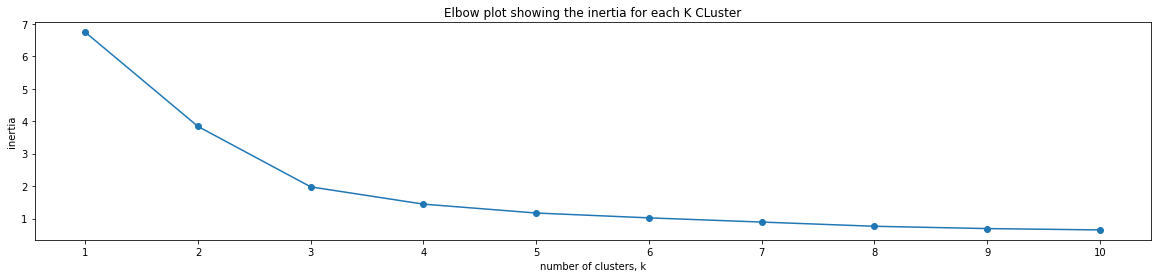

In [15]:
ks = range(1, 11)
inertias = []
models = []
models.append(np.nan)

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k, random_state = 42)
    models.append(model)
    # Fit model to samples
    model.fit(df_prepro)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.figure(figsize = (20,4))
plt.plot(ks, inertias, '-o')
plt.title("Elbow plot showing the inertia for each K CLuster")
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


We now need to decide how many clusters are best.

We're looking for 10 similar regions to Saint Petersburg.  Based on the number of regions, clusting our data into 6 or 7 groups would be ideal.  Lets try 6 clusters.

In [16]:
region_labels = pd.DataFrame(df_prepro.index)
region_labels["label"] = models[6].labels_
label_SP = region_labels.loc[region_labels.region == "Saint Petersburg", "label"].values[0]
print(color.BOLD + f"K Means of 6 results in Saint Petersburg being in a group of: {len(region_labels[region_labels.label == label_SP])}" + color.END)
region_labels = region_labels[region_labels.label == label_SP]
region_labels


K Means of 6 results in Saint Petersburg being in a group of: 11


,region,label
1,Altai Republic,4
22,Komi Republic,4
23,Kostroma Oblast,4
28,Leningrad Oblast,4
46,Republic of Adygea,4
49,Republic of Crimea,4
54,Republic of Mordovia,4
59,Saint Petersburg,4
78,Vologda Oblast,4
81,Yaroslavl Oblast,4


Perfect! This is just the number we were looking for.  I wonder how these regions compare to Saint Petersburg?

**CHANGE THE BELOW PLOT TO SHOW EXAMPLES OF THE K MEANS EFFECTIVENESS**

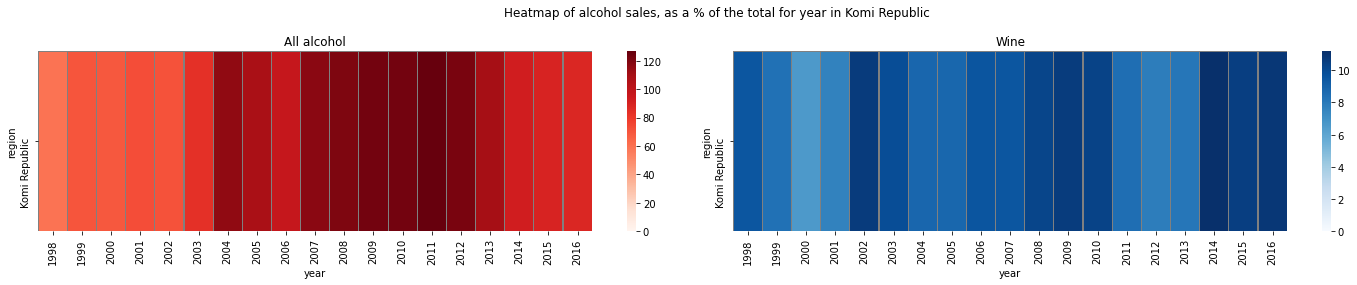

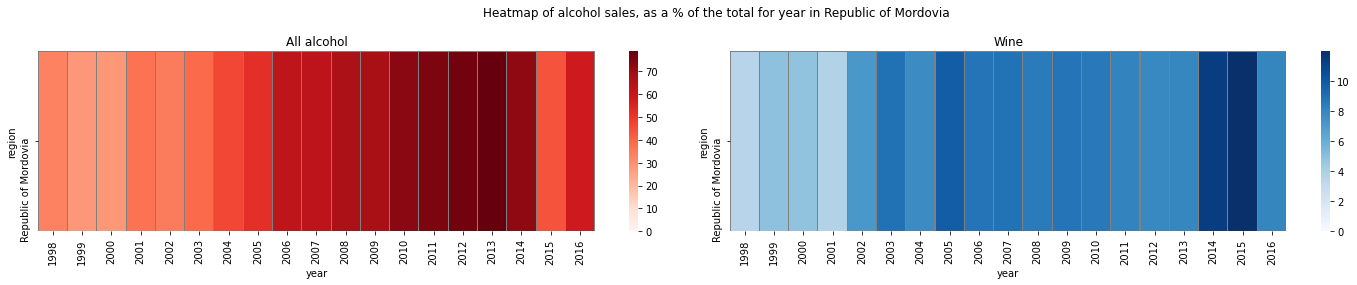

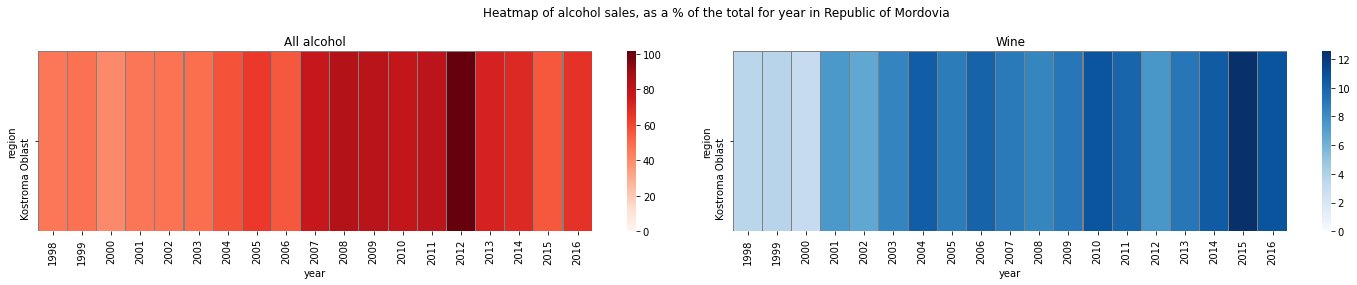

In [17]:
df_eda2 = df_cleaned[df_cleaned.region.isin(region_labels.region)].sort_values(by=["region", "year"])
df_eda2["wine"] = (df_eda2.wine / df_eda2.total) * 100
df_eda2["year"] = df_eda2.year.astype(str)
df_eda2 = df_eda2[["year", "region", "wine", "total"]].reset_index(drop=True)


r1 = df_eda2[df_eda2.region==region_labels.reset_index(drop=True).region[1]]
df_eda_total_r1 = pd.pivot_table(r1[["year", "region", "total"]], values="total", index="region", columns=["year"])
df_eda_wine_r1 = pd.pivot_table(r1[["year", "region", "wine"]], values="wine", index="region", columns=["year"])

r2 = df_eda2[df_eda2.region==region_labels.reset_index(drop=True).region[6]]
df_eda_total_r2 = pd.pivot_table(r2[["year", "region", "total"]], values="total", index="region", columns=["year"])
df_eda_wine_r2 = pd.pivot_table(r2[["year", "region", "wine"]], values="wine", index="region", columns=["year"])

r3 = df_eda2[df_eda2.region==region_labels.reset_index(drop=True).region[2]]
df_eda_total_r3 = pd.pivot_table(r3[["year", "region", "total"]], values="total", index="region", columns=["year"])
df_eda_wine_r3 = pd.pivot_table(r3[["year", "region", "wine"]], values="wine", index="region", columns=["year"])



plt.figure(figsize = (20,4))

plt.suptitle(f"Heatmap of alcohol sales, as a % of the total for year in {df_eda_total_r1.index[0]}")
plt.subplot(1, 2, 1)
plt.title("All alcohol")
sns.heatmap(df_eda_total_r1, vmin = 0, cmap = "Reds", linecolor = "grey", linewidth = 0.1)

plt.subplot(1, 2, 2)
plt.title("Wine")
sns.heatmap(df_eda_wine_r1, vmin = 0, cmap = "Blues", linecolor = "grey", linewidth = 0.1)

plt.tight_layout()
plt.show()


plt.figure(figsize = (20,4))

plt.suptitle(f"Heatmap of alcohol sales, as a % of the total for year in {df_eda_total_r2.index[0]}")
plt.subplot(1, 2, 1)
plt.title("All alcohol")
sns.heatmap(df_eda_total_r2, vmin = 0, cmap = "Reds", linecolor = "grey", linewidth = 0.1)

plt.subplot(1, 2, 2)
plt.title("Wine")
sns.heatmap(df_eda_wine_r2, vmin = 0, cmap = "Blues", linecolor = "grey", linewidth = 0.1)

plt.tight_layout()
plt.show()



plt.figure(figsize = (20,4))

plt.suptitle(f"Heatmap of alcohol sales, as a % of the total for year in {df_eda_total_r2.index[0]}")
plt.subplot(1, 2, 1)
plt.title("All alcohol")
sns.heatmap(df_eda_total_r3, vmin = 0, cmap = "Reds", linecolor = "grey", linewidth = 0.1)

plt.subplot(1, 2, 2)
plt.title("Wine")
sns.heatmap(df_eda_wine_r3, vmin = 0, cmap = "Blues", linecolor = "grey", linewidth = 0.1)

plt.tight_layout()
plt.show()

This looks good.  We've picked three regions from the K-Means model and visually they look similar
 - There were previously higher sales
 - The recent wine sales has started to increase in recent years
 - The total % of wine sales are relatively low in comparision to the regions total sales.

In [18]:
df_groupings["kmeans"] = df_groupings.region.isin(region_labels.region)

### 3.2 RFM

I'm unsure how effective RFM (recency, frequency, monetary) clustering will be.  This is because we're not looking at individual customer orders. However, it might still give us some interesting insight:
 - We'll focus on the latest year (2016) - only.
 - The recency will always be '1' because each region left in our dataframe has purchased alcohol in 2016.
 - We'll set the frequency to be the percentage of sales that was wine per region
 - We'll set the monetry to the sale of wine in litres by year per captia

In [19]:
df_RFM = df_cleaned.copy()
df_RFM["region"] = df_RFM.region.astype("category")
df_RFM = df_RFM[df_RFM.year == 2016]
df_RFM["wine_pct"] = (df_RFM.wine / df_RFM.total)



df_RFM = df_RFM.melt(id_vars = ["region"], 
                     value_vars = ["wine", "wine_pct"]) \
              .pivot(values = ["value"], index = "region", columns = ["variable"])
df_RFM.columns = ["monetary", "frequency"]
df_RFM["recency"] = 1

df_RFM['r_quartile'] = 1
df_RFM['f_quartile'] = pd.qcut(df_RFM['frequency'], 4, ['4','3','2','1'])
df_RFM['m_quartile'] = pd.qcut(df_RFM['monetary'], 4, ['4','3','2','1'])


df_RFM['RFM_Score'] = df_RFM.r_quartile.astype(str)+ df_RFM.f_quartile.astype(str) + df_RFM.m_quartile.astype(str)

rfm_score = df_RFM.loc[df_RFM.index == "Saint Petersburg"].RFM_Score[0]
df_RFM = df_RFM[df_RFM.RFM_Score == rfm_score]
print(color.HEADER + "RFM table for each region that as the same score as Saint Petersburg" + color.END)
df_RFM


RFM table for each region that as the same score as Saint Petersburg


,monetary,frequency,recency,r_quartile,f_quartile,m_quartile,RFM_Score
region,,,,,,,
Bryansk Oblast,7.0,0.146138,1,1,1,2,112
Lipetsk Oblast,6.2,0.119231,1,1,1,2,112
Oryol Oblast,6.4,0.113475,1,1,1,2,112
Ryazan Oblast,6.3,0.116451,1,1,1,2,112
Saint Petersburg,7.1,0.141434,1,1,1,2,112
Zabaykalsky Krai,6.4,0.141593,1,1,1,2,112


In [20]:
df_groupings["rfm"] = df_groupings.region.isin(df_RFM.index)

### 3.3 NMF (Non-Negative Matrix Factorization)

For our third and final model, we'll use an NMF to see which regions appear most like Saint Petersburg.

We'll prepare our data before transforming it into a CSR_Matrix.  We'll then use a pipeline to scale the data and normalize it.

In [21]:
df_CSR = df_cleaned
df_CSR = df_CSR[df_CSR.year == 2016].set_index("region")
df_CSR = df_CSR[["wine", "beer", "vodka", "champagne", "brandy"]]
print(color.HEADER + "Dataframe prior to scaling and normalization" + color.END)
df_CSR

Dataframe prior to scaling and normalization


,wine,beer,vodka,champagne,brandy
region,,,,,
Republic of Adygea,3.6,27.3,3.6,1.0,0.5
Altai Krai,4.8,37.3,4.5,0.7,0.3
Amur Oblast,6.2,46.9,6.0,1.3,0.5
Arkhangelsk Oblast,8.4,51.6,12.2,1.8,0.9
Astrakhan Oblast,4.5,38.3,4.5,0.9,0.6
...,...,...,...,...,...
Chuvash Republic,5.0,42.3,7.7,0.7,0.4
Chukotka Autonomous Okrug,3.9,34.0,11.6,1.8,1.1
Sakha (Yakutia) Republic,4.3,56.1,8.2,1.8,0.5


In [22]:
dataset = csr_matrix(df_CSR)

scaler = MaxAbsScaler()

nmf = NMF(n_components = 20)

normalizer = Normalizer()

pipeline = make_pipeline(scaler, nmf, normalizer)

norm_features = pipeline.fit_transform(dataset)


In [23]:
# Create a DataFrame: df
dataframe = pd.DataFrame(norm_features, index = df_prepro.index)
region = dataframe.loc["Saint Petersburg"]

similarities = dataframe.dot(region)
df_NMF_rank = pd.DataFrame(similarities).reset_index()
df_NMF_rank = df_NMF_rank.set_index("region")[0].nlargest(n=11)
print(color.HEADER + "Which regions are most like Saint Petersburg?" + color.END)
df_NMF_rank

Which regions are most like Saint Petersburg?


region
Saint Petersburg            1.000000
Volgograd Oblast            0.932750
Amur Oblast                 0.927541
Rostov Oblast               0.927244
Tula Oblast                 0.924484
Chelyabinsk Oblast          0.914635
Stavropol Krai              0.911600
Republic of Tatarstan       0.908741
Primorsky Krai              0.902622
Jewish Autonomous Oblast    0.899825
Leningrad Oblast            0.899408
Name: 0, dtype: float64

In [24]:
df_groupings["nmf"] = df_groupings.region.isin(df_NMF_rank.index)

## 4.0 Analysis of outcomes
Great.  We've now completed our three models.  Let's score each region:
 - Each region gets a score of 1 for each model it appears in (maximum of 3)
 - We'll sort the scores to give kmeans the most importance, followed by RFM and then NMF
     - In other words, a region that only appears in kmeans will be ranked higher than a region that only appears in rfm or nmf.
 - We'll filter our data to only show the top 10 regions that are closest to Saint Petersburg

In [25]:
df_groupings["score"] = df_groupings.kmeans.astype(int) + df_groupings.rfm.astype(int) + df_groupings.nmf.astype(int)
final = df_groupings[df_groupings.score > 0].sort_values(["score", "kmeans", "rfm", "nmf"], ascending = False).reset_index(drop=True)
final.iloc[:11]

,region,kmeans,rfm,nmf,score
0,Saint Petersburg,True,True,True,3
1,Zabaykalsky Krai,True,True,False,2
2,Leningrad Oblast,True,False,True,2
3,Republic of Adygea,True,False,False,1
4,Vologda Oblast,True,False,False,1
5,Kostroma Oblast,True,False,False,1
6,Republic of Crimea,True,False,False,1
7,Republic of Mordovia,True,False,False,1
8,Altai Republic,True,False,False,1
9,Komi Republic,True,False,False,1


And there we have it, our 10 recommended regions.

## 5.0 Next steps and the future
In order to validate our analysis, we'll need our assumptions confirmed.
If we were to obtain more detail, it would be great to analysis the regions against other features, such as their demographics and the competition.

James Morgan